[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/5.0-GAIA-fashion-mnist.ipynb)

## Generative adversarial interpolative autoencoder (GAIA) ([article](https://arxiv.org/abs/1807.06650)) 
GAIA is an autoencoder trained to learn convex latent representations by adversarially training on interpolations in latent space projections of real data. 

![generative adversarial interpolative autoencoding network](imgs/gaia.png)

### Install packages if in colab

In [1]:
# make visible the only one GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513",
                      "pip install tfp-nightly==0.7.0.dev20190508",
]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

#### Note: This is a modified version of GAIA from the [original manuscript](https://arxiv.org/abs/1807.06650). It's been simplified significantly and no longer requires any hyperparameters (other than learning rate).

### load packages

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from tensorflow_probability.python.distributions import Chi2

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow_probability as tfp

In [7]:
print(tf.__version__, tfp.__version__)

2.0.0-dev20190513 0.7.0-dev20190510


### Create a fashion-MNIST dataset

In [4]:
TRAIN_BUF=60000
BATCH_SIZE=64
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [5]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

### Define the network as tf.keras.model object

In [6]:
class GAIA(tf.keras.Model):
    """a basic gaia class for tensorflow

    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAIA, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

        inputs, outputs = self.unet_function()
        self.disc = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        return self.dec(z)

    def discriminate(self, x):
        return self.disc(x)

    def regularization(self, x1, x2):
        return tf.reduce_mean(tf.square(x1 - x2))

    @tf.function
    def network_pass(self, x):
        z = self.encode(x)
        xg = self.decode(z)
        zi = self._interpolate_z(z)
        xi = self.decode(zi)
        d_xi = self.discriminate(xi)
        d_x = self.discriminate(x)
        d_xg = self.discriminate(xg)
        return z, xg, zi, xi, d_xi, d_x, d_xg

    @tf.function
    def compute_loss(self, x):
        # run through network
        z, xg, zi, xi, d_xi, d_x, d_xg = self.network_pass(x)

        # compute losses
        xg_loss = self.regularization(x, xg)
        d_xg_loss = self.regularization(x, d_xg)
        d_xi_loss = self.regularization(xi, d_xi)
        d_x_loss = self.regularization(x, d_x)
        return d_xg_loss, d_xi_loss, d_x_loss, xg_loss

    @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            d_xg_loss, d_xi_loss, d_x_loss, xg_loss = self.compute_loss(x)

            gen_loss = d_xg_loss + d_xi_loss
            disc_loss = d_xg_loss + d_x_loss - tf.clip_by_value(d_xi_loss, 0, d_x_loss)

        gen_gradients = gen_tape.gradient(
            gen_loss, self.enc.trainable_variables + self.dec.trainable_variables
        ) 
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
        return gen_gradients, disc_gradients

    @tf.function
    def apply_gradients(self, gen_gradients, disc_gradients):
        self.gen_optimizer.apply_gradients(
            zip(
                gen_gradients,
                self.enc.trainable_variables + self.dec.trainable_variables,
            )
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    
    @tf.function
    def train(self, x):
        gen_gradients, disc_gradients = self.compute_gradients(x)
        self.apply_gradients(gen_gradients, disc_gradients)

    def _interpolate_z(self, z):
        """ takes the dot product of some random tensor of batch_size,
         and the z representation of the batch as the interpolation
        """
        if self.chsq.df != z.shape[0]:
            self.chsq = Chi2(df=1 / z.shape[0])
        ip = self.chsq.sample((z.shape[0], z.shape[0]))
        ip = ip / tf.reduce_sum(ip, axis=0)
        zi = tf.transpose(tf.tensordot(tf.transpose(z), ip, axes=1))
        return zi


def sigmoid(x, shift=0.0, mult=20):
    """ squashes a value with a sigmoid
    """
    return tf.constant(1.0) / (
        tf.constant(1.0) + tf.exp(-tf.constant(1.0) * ((x + tf.constant(shift)) * mult))
    )

### Define the network architecture
- GAIA has an autoencoder as its generator, and a UNET as its descriminator

In [7]:
N_Z = 128

In [8]:
def unet_convblock_down(
    _input,
    channels=16,
    kernel=(3, 3),
    activation="relu",
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    """ An upsampling convolutional block for a UNET
    """
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(_input)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(conv)
    return conv, pool


def unet_convblock_up(
    last_conv,
    cross_conv,
    channels=16,
    kernel=(3, 3),
    activation="relu",
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    """ A downsampling convolutional block for a UNET
    """

    up_conv = tf.keras.layers.UpSampling2D(size=(2, 2))(last_conv)
    merge = tf.keras.layers.concatenate([up_conv, cross_conv], axis=3)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(merge)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    return conv


def unet_mnist():
    """ the architecture for a UNET specific to MNIST
    """
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    up_1, pool_1 = unet_convblock_down(inputs, channels=32)
    up_2, pool_2 = unet_convblock_down(pool_1, channels=64)
    conv_middle = tf.keras.layers.Conv2D(
        128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
    )(pool_2)
    conv_middle = tf.keras.layers.Conv2D(
        128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
    )(conv_middle)
    down_2 = unet_convblock_up(conv_middle, up_2, channels=64)
    down_1 = unet_convblock_up(down_2, up_1, channels=32)
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(down_1)
    return inputs, outputs


encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

### Create Model

In [9]:
# the unet function 
gen_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(1e-3)
    
# model
model = GAIA(
    enc = encoder,
    dec = decoder,
    unet_function = unet_mnist,
    gen_optimizer=gen_optimizer,
    disc_optimizer = disc_optimizer,
    chsq = Chi2(df=1 / BATCH_SIZE)
)

### Train the model

In [10]:
# exampled data for plotting results
example_data = next(iter(train_dataset))

In [11]:
model.train(example_data)

In [12]:
def plot_reconstruction(model, example_data, nex=5, zm=3):
    z, xg, zi, xi, d_xi, d_x, d_xg = model.network_pass(example_data)
    fig, axs = plt.subplots(ncols=6, nrows = nex, figsize=(zm*6, zm*nex))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, d_x, xg, d_xg, xi, d_xi],
            ["data", "disc data","gen", "disc gen", "interp", "disc interp"],
        )
    ):
        for ex in range(nex):
            axs[ex, axi].matshow(dat.numpy()[ex].squeeze(), cmap = plt.cm.Greys, vmin=0, vmax=1)
            axs[ex, axi].axis('off')
        axs[0, axi].set_title(lab)
        
    plt.show()

In [13]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['d_xg_loss', 'd_xi_loss', 'd_x_loss', 'xg_loss'])

Epoch: 49


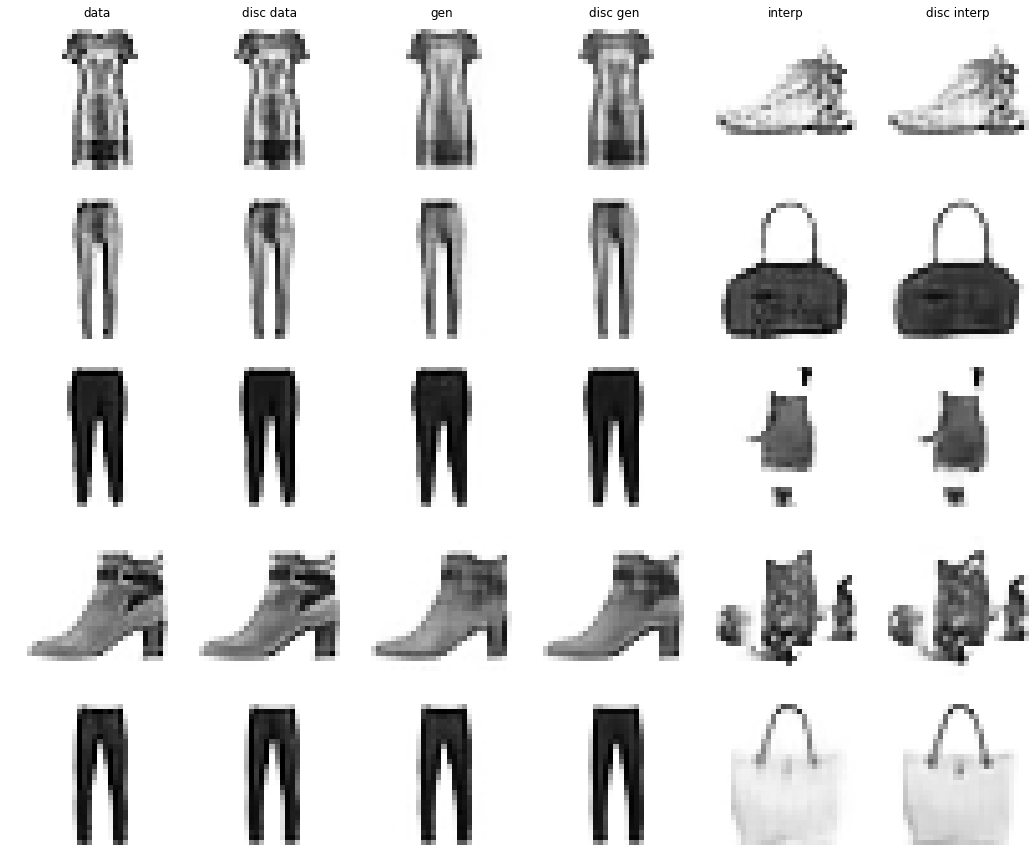

In [17]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), train_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {}".format(epoch)
    )
    plot_reconstruction(model, example_data)